In [1]:
import os, sys

import numpy as np

import torch
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../..')

In [3]:
from lib.datasets import get_train_test_img_ids_split, get_kfolds
from lib.dataloaders import PatchesDataset
from lib.augmentations import augment_v1

In [4]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

In [5]:
train_img_ids[:4], test_img_ids[:4]

(['eaf66ac783499827a7f09d69793a07d7',
  'ea035a96c752f59a4934a91068b318f2',
  '4c0d7290c72b5495df6c337b1e5dee88',
  '9edf591d741baf346fc1ff0f42dd4ddc'],
 ['e8baa3bb9dcfb9cef5ca599d62bb8046',
  '9b2948ff81b64677a1a152a1532c1a50',
  '5b003d43ec0ce5979062442486f84cf7',
  '375b2c9501320b35ceb638a3274812aa'])

In [6]:
#%%time
#img, mask, labes, provider, isup_grade, g_score = next(iter(train_loader))

In [7]:
import torch
import torchvision
from torchsummary import summary
from torch import optim

from torch.nn import functional as F
from torch import nn

In [8]:
device = torch.device('cuda:0')

In [9]:
# import pretrainedmodels

In [10]:
# backbone_model = pretrainedmodels.se_resnet50()
# backbone_model = torchvision.models.resnet18(num_classes=9)

In [11]:
#backbone_model.avg_pool = nn.Identity()
#backbone_model.last_linear = nn.Identity()

In [12]:
#sys.path.append('../../../captcha/lib/')

In [13]:
#from models import resnet_mini_custom

In [14]:
import copy
from segmentation_models_pytorch.encoders import get_encoder, get_encoder_names, encoders
from segmentation_models_pytorch.unet import Unet
import segmentation_models_pytorch

In [15]:
from segmentation_models_pytorch.unet.decoder import DecoderBlock

In [16]:
X = torch.rand((64, 3, 256, 256), device=device)

In [17]:
# activation для масок не забыть!!!
model = Unet('resnet18', encoder_weights=None, classes=9, aux_params={'classes': 9})

In [18]:
#import inspect
#lines = inspect.getsource(model.forward)
#print(lines)

import types

def forward(self, x):
    """Sequentially pass `x` trough model`s encoder, decoder and heads"""
    features = self.encoder(x)
    # decoder_output = self.decoder(*features)
    masks = None
    #masks = self.segmentation_head(decoder_output)
    
    out = masks

    if self.classification_head is not None:
        labels = self.classification_head(features[-1])
        out = (masks, labels)
    
    if self.autodecoder is not None:
        decoded = self.autodecoder(features[-1])
        out = (masks, labels, decoded)

    return out

model.forward = types.MethodType(forward, model)
model.autodecoder = None

In [19]:
class AutoDecoder(nn.Module):
    def __init__(
            self,
            channels,
            use_batchnorm=True,
            attention_type=None,
    ):
        super().__init__()

        in_channels = channels[:0:-1]
        out_channels = channels[-2::-1]        
        
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)        
        blocks = [
            DecoderBlock(in_ch, 0, out_ch, **kwargs)
            for in_ch, out_ch in zip(in_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, features):
        x = features
        
        for i, decoder_block in enumerate(self.blocks):
            x = decoder_block(x)
            
        x = torch.sigmoid(x)
        # x = torch.tanh(x)

        return x

In [20]:
channels = model.encoder.out_channels
model.autodecoder = AutoDecoder(channels)

In [21]:
#model = torchvision.models.resnet18(num_classes=9)

In [22]:
model.to(device);

In [23]:
%%time
with torch.no_grad():
    tmp = model(X)
    tmp[1].sum().item()

CPU times: user 239 ms, sys: 62.6 ms, total: 302 ms
Wall time: 445 ms


In [24]:
None, tmp[1].shape, tmp[2].shape,

(None, torch.Size([64, 9]), torch.Size([64, 3, 256, 256]))

In [25]:
sum([p.data.numel() for p in model.parameters()])

16734015

In [26]:
sum([p.data.numel() for p in model.autodecoder.parameters()])

2400029

In [27]:
#backbone_model = resnet_mini_custom.resnet20_c7_fls2(num_classes=9)

In [28]:
#backbone_model.conv1 = nn.Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)

In [29]:
#summary(backbone_model, (3, 512, 512), -1, 'cpu')

In [30]:
#backbone_model.to(device);

In [31]:
from tqdm.auto import tqdm

In [32]:
class SmoothLoss:
    "A simple loss compute and train function."
    def __init__(self, criterion, smoothing=0.1):
        self.criterion = criterion
        self.smoothing = smoothing
        self.confidence = 1 - smoothing
        
    def __call__(self, output, target):
        smooth_target = target
        # smooth_target = torch.full_like(output, self.smoothing / (output.size(1) - 1))
        # smooth_target.scatter_(1, target[:, None, :], self.confidence)
        loss = self.criterion(output, smooth_target)
        return loss

In [33]:
c_criterion0 = SmoothLoss(lambda o, t: F.kl_div(o, t) * o.size(1), smoothing=0.1)
criterion = c_criterion0
a_criterion = nn.MSELoss()

In [34]:
# model = backbone_model

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999, last_epoch=-1)

In [36]:
batch_size = 64

In [37]:
train_loader = torch.utils.data.DataLoader(
    PatchesDataset(train_img_ids, transform=augment_v1, scale=0.5, load_masks=False),
    batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    PatchesDataset(test_img_ids, transform=None, scale=0.5, load_masks=False),
    batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True,
)

In [38]:
for img, mask, labels, provider, isup_grade, g_score in train_loader:
    
    break

In [39]:
img.transpose(0, 1).reshape(3, -1).mean(dim=-1)

tensor([0.8862, 0.7819, 0.8483])

In [40]:
img.transpose(0, 1).reshape(3, -1).std(dim=-1)

tensor([0.1414, 0.2483, 0.1660])

In [41]:
#rgb_mean = torch.tensor([0.88, 0.76, 0.84])[None, :, None, None].to(device)
#rgb_std = torch.tensor([0.15, 0.26, 0.18])[None, :, None, None].to(device)
# normalize = transforms.Normalize([0.88, 0.76, 0.84], [0.15, 0.26, 0.18], inplace=True)
rgb_mean = torch.tensor([0.5, 0.5, 0.5])[None, :, None, None].to(device)
rgb_std = torch.tensor([0.5, 0.5, 0.5])[None, :, None, None].to(device)

In [42]:
import itertools

In [43]:
train_loader_iter = iter(itertools.cycle(train_loader))

In [ ]:
%%time
img, mask, labels, provider, isup_grade, g_score = next(train_loader_iter)

In [45]:
for epoch in range(1):
    t_loss = 0
    cnt = 0
    model.train()
    c_t_loss = 0
    with tqdm(total=len(train_loader)) as pbar:
        for img, mask, labels, provider, isup_grade, g_score in train_loader:
            img = (img.to(device) - rgb_mean) / rgb_std
 
            optimizer.zero_grad()
            _, _, output = model(img)

            loss = a_criterion(output, img)
            loss.backward()
            optimizer.step()
            c_t_loss = loss.item()
            t_loss += loss.item() * img.shape[0]
            cnt += img.shape[0]
            
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
            pbar.update(1)
            
            lr_scheduler.step()
        
    t_loss /= cnt
    
    
    '''
    v_loss = 0
    cnt = 0   
    model.eval()
    with torch.no_grad():
        for img, mask, labels, provider, isup_grade, g_score in val_loader:
            img = img.to(device) / 255
            _, _, output = model(img)
            loss = a_criterion(output, img)
            v_loss += loss.item() * img.shape[0]
            cnt += img.shape[0]
        
    v_loss /= cnt
    '''
    v_loss = 0
    
    print(f"{epoch}. train loss: {t_loss:.4f}, val loss: {v_loss:.4f}, lr: {optimizer.param_groups[0]['lr']:.6f}")


0. train loss: 0.0241, val loss: 0.0000, lr: 0.000040


In [46]:
# , sigmoid
# 9% 2941/32214 [15:08<2:30:43, 3.24it/s, loss=0.00863, lr=0.000745]

# - mean, tanh
# 10% 3111/32214 [16:02<2:30:02, 3.23it/s, loss=0.0216, lr=0.000733]

In [52]:
# None
# 32214/32214 [2:48:24<00:00, 3.19it/s, loss=0.00425, lr=3.99e-5]
# torch.save(model.state_dict(), 'resnet18_autoencoder_1ep.pth')

# Tanh, 0.5 0.5
# 32214/32214 [2:43:09<00:00, 3.29it/s, loss=0.0192, lr=3.99e-5]
# torch.save(model.state_dict(), 'resnet18_autoencoder_1ep_tanh.pth')

In [67]:
# model.load_state_dict(torch.load('resnet18_autoencoder_1ep.pth'))

<All keys matched successfully>

In [46]:
model.eval();

In [49]:
val_loader = torch.utils.data.DataLoader(
    PatchesDataset(test_img_ids, transform=None, scale=0.5, load_masks=False),
    batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True,
)

In [50]:
with torch.no_grad():
    for img, mask, labels, provider, isup_grade, g_score in val_loader:
        img = img.to(device) / 255
        img = (img.to(device) - rgb_mean) / rgb_std
        
        _, _, output = model(img)
        
        img = (img * rgb_std) + rgb_mean
        output = (output * rgb_std) + rgb_mean
        
        break

In [51]:
with torch.no_grad():
    _, _, output = model(img)

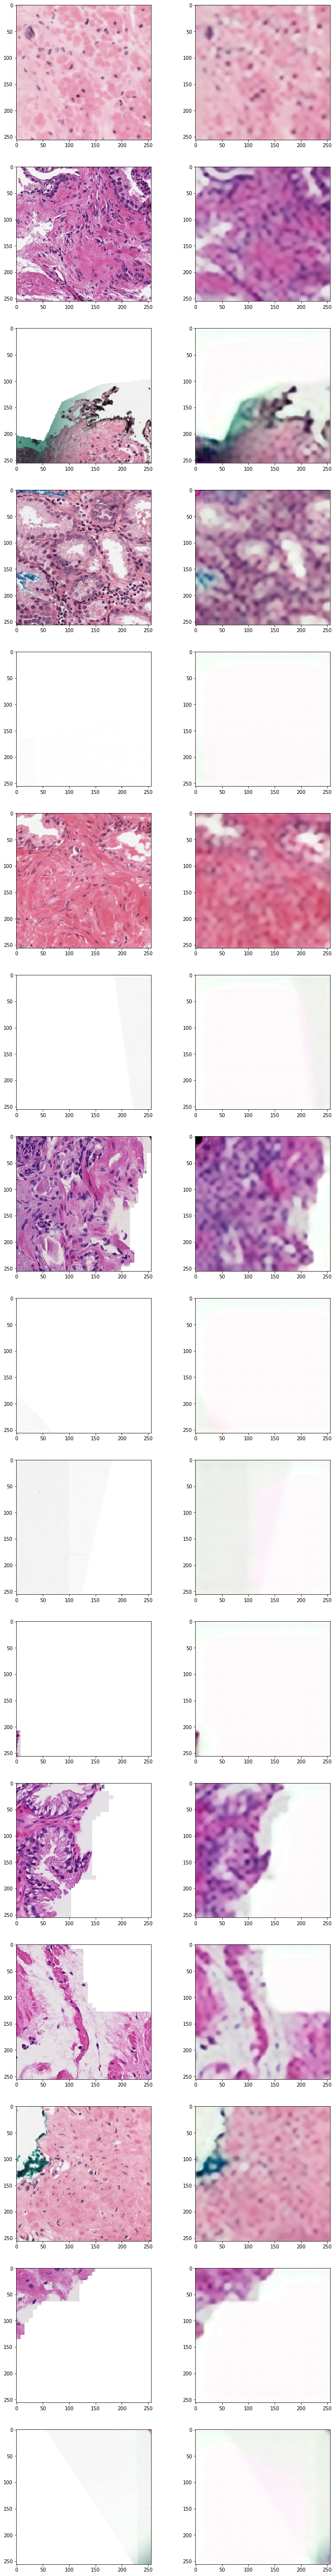

In [69]:
fig, axs = plt.subplots(16, 2, figsize=(12, 6*16))

for n in range(16):
    o_img = img[n].cpu().numpy().transpose(1, 2, 0)
    r_img = output[n].cpu().numpy().transpose(1, 2, 0)
    r_img = np.clip(r_img, 0, 1)

    axs[n][0].imshow(o_img);
    axs[n][1].imshow(r_img);

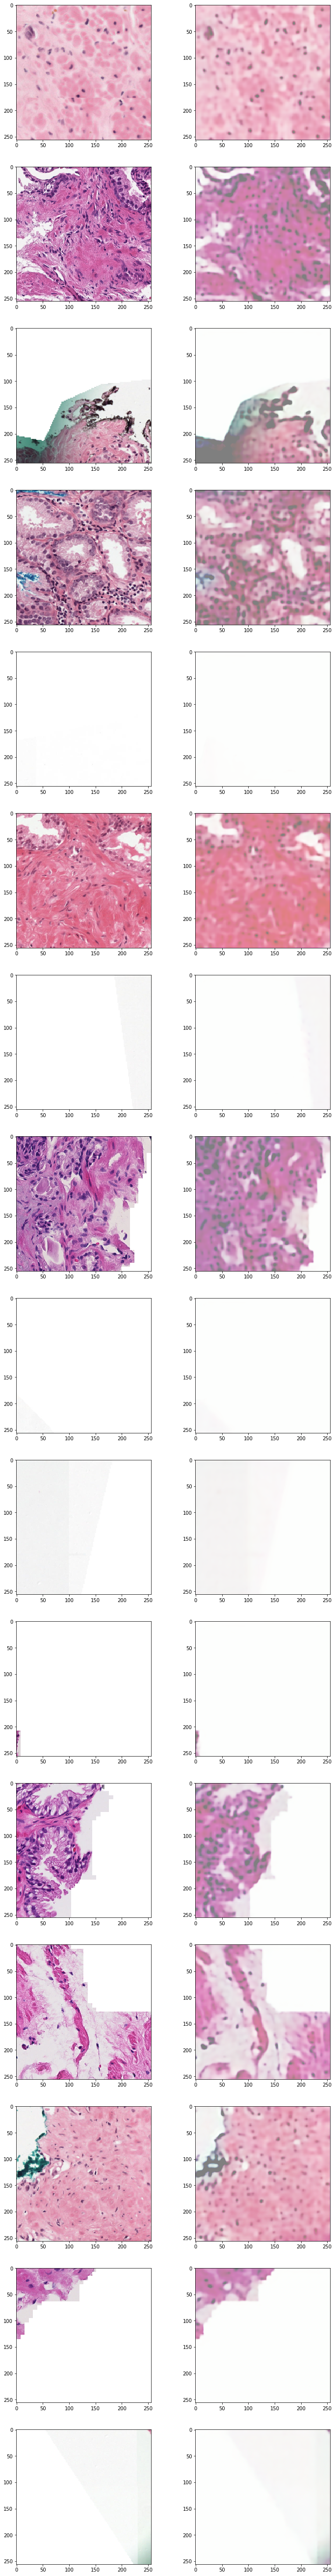

In [51]:
fig, axs = plt.subplots(16, 2, figsize=(12, 6*16))

for n in range(16):
    o_img = img[n].cpu().numpy().transpose(1, 2, 0)
    r_img = output[n].cpu().numpy().transpose(1, 2, 0)
    r_img = np.clip(r_img, 0, 1)

    axs[n][0].imshow(o_img);
    axs[n][1].imshow(r_img);

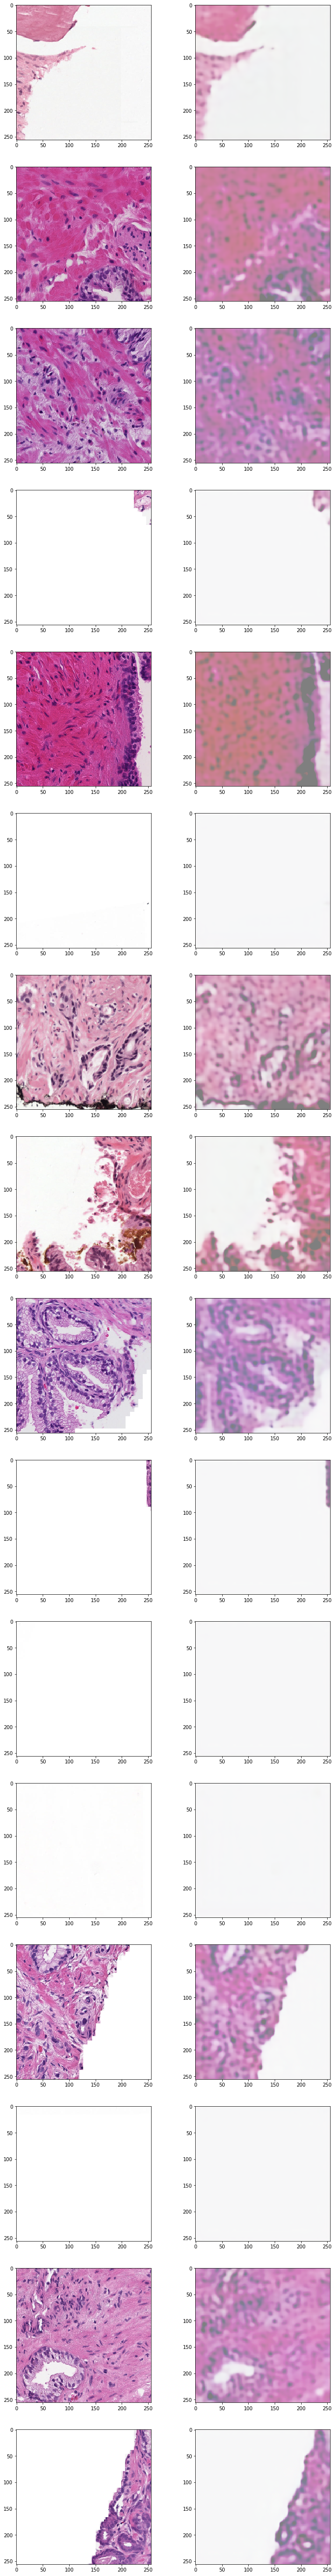

In [52]:
fig, axs = plt.subplots(16, 2, figsize=(12, 6*16))

for n in range(16):
    o_img = img[n].cpu().numpy().transpose(1, 2, 0)
    r_img = output[n].cpu().numpy().transpose(1, 2, 0)
    r_img = np.clip(r_img, 0, 1)

    axs[n][0].imshow(o_img);
    axs[n][1].imshow(r_img);